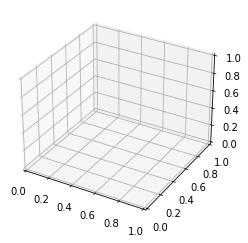

In [1]:
import sklearn
import numpy as np
import csv
import pickle
import time
import os
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

from utils_general import utils_for_students

train_samples = utils_for_students.load_dataset_stage2('data/stage2_labels_train.csv', 'train')
test_samples = utils_for_students.load_dataset_stage2('data/stage2_ids_test.csv', 'test')

In [2]:
#Feature extraction 1
import importlib
from utils_feature_preprocessing.transform_frames import transform_to_k_frames, frames_to_features
from utils_feature_preprocessing.correct_zeros_interpolation import correct_zeros_interpolation
from utils_feature_preprocessing.straighten_pose_old import straighten_pose_seq
from utils_feature_preprocessing.hand_movement import hand_movement
from utils_feature_preprocessing.pose_hands import pose_hand
from utils_feature_preprocessing.connections import connections_body    
from test_feature_preprocessing.index_uitgestrekt import index_uitgestrekt
from  utils_feature_preprocessing.features_from_hand import extract_finger_curviness
from utils_feature_preprocessing.minimumFingerEye import minimumFingerEye
def extract_features(pose_sequence):
    # You should implement this function to return better features!
    pose_sequence = correct_zeros_interpolation(pose_sequence)

    hand_mov = hand_movement(pose_sequence)
    hand_features = pose_hand(pose_sequence)
    fingers = index_uitgestrekt(pose_sequence)
    
    #To make the model more robust we remove the face values (robustness of model)
    pose_sequence = straighten_pose_seq(pose_sequence)
    curve = extract_finger_curviness(pose_sequence)
    dist_eye = minimumFingerEye(pose_sequence)
    #this only keeps the body connections not the face
    body_sequence = connections_body(pose_sequence)
    # We make sure that the viewpoint is the same for all sequences (robustness of model)
    body_sequence = transform_to_k_frames(body_sequence, k=3)
    body_features = frames_to_features(body_sequence)
    features = np.concatenate((body_features, fingers,hand_features,[dist_eye], hand_mov, curve))
    return features

In [3]:
pose_sequence = utils_for_students.load_sample_stage2(os.path.join('data/stage2/train/', train_samples[0]['path']))
pose_sequence = correct_zeros_interpolation(pose_sequence)

hand_mov = hand_movement(pose_sequence)
hand_features = pose_hand(pose_sequence)
index = index_uitgestrekt(pose_sequence)
    
#To make the model more robust we remove the face values (robustness of model)
pose_sequence = straighten_pose_seq(pose_sequence)
curve = extract_finger_curviness(pose_sequence)
#this only keeps the body connections not the face
body_sequence = connections_body(pose_sequence)
# We make sure that the viewpoint is the same for all sequences (robustness of model)
body_sequence = transform_to_k_frames(body_sequence, k=3)
body_features = frames_to_features(body_sequence)

print(body_features.shape)
print(index.shape)

(225,)
(10,)


C:\Users\utilisateur\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [4]:
# Concatenate the training set features.
X_train = []
y_train = []
signers_train = []
for sample in train_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('data/stage2/train/', sample['path']))
    X_train.append(extract_features(pose_sequence))
    y_train.append(sample['label'])
    signers_train.append(sample['signer'])
    
# Concatenate the test set features.
X_test = []
test_ids = []
for sample in test_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('data/stage2/test/', sample['path']))
    X_test.append(extract_features(pose_sequence))
    test_ids.append(sample['id'])

#Combining to numpy array
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Encode the labels as integers
label_encoder = utils_for_students.label_encoder()
y_train = label_encoder.transform(y_train)

In [5]:
class selectBodyFeatures(object):
    #235 
    def transform(self, X):
        
        return X[:,:235]

    def fit(self, X, y=None):
        return self

class selectHandFeatures(object):
    def transform(self, X):
        return X[:,235:]

    def fit(self, X, y=None):
        return self

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
w = {}
for c in range(15):
    w[c] = 0

w[11] = 147
w[13] = 200

preprocessing = Pipeline([
     ('scaler', StandardScaler()),
     ('decompose', PCA()),
                        ]) 
robust_preprocessing = Pipeline([
     ('scaler', RobustScaler()),
     ('decompose', PCA()),
                        ]) 
#TODO: define feature selection pipeline here
feature_selection = Pipeline([
    ('selectKBest', SelectKBest()),
                            ])
feature_selection_2 = Pipeline([
    ('selectKBest', SelectKBest()),
                            ])
classifier_body = make_pipeline(selectBodyFeatures(), robust_preprocessing, feature_selection, RidgeClassifier(class_weight='balanced'))
classifier_hand = make_pipeline(selectHandFeatures(), preprocessing, feature_selection, RidgeClassifier(class_weight='balanced'))
classifier_ook = make_pipeline( preprocessing, feature_selection, RidgeClassifier(class_weight=w))
estimators = [
    ('kn', classifier_body),
    ('ridge', classifier_hand),
    #('ook', classifier_ook)
    ]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=2000), passthrough=False
    )

In [7]:
param_grid = {
    #'preprocessing__decompose__n_components': [None],
    #'preprocessing__decompose__whiten': [False],#[True, False],
    'kn__pipeline-1__decompose__n_components':[None],
    'kn__pipeline-1__decompose__whiten':[False],
    'kn__pipeline-2__selectKBest__k': [100],
    'ridge__pipeline-2__selectKBest__k': [110],
    'final_estimator__C':[10,1,0.1,0.01],
    'final_estimator__class_weight':['balanced'],
    'final_estimator__penalty' : ['l2'],
    'final_estimator__solver' : [ 'lbfgs'],
    #'final_estimator__intercept_scaling':[0.001,0.01,0.1,1],
    'ridge__ridgeclassifier__alpha':[100],
    'ridge__ridgeclassifier__tol':[1.0e-5],
    'ridge__ridgeclassifier__fit_intercept':[True],
    'kn__ridgeclassifier__alpha':[100],
    'kn__ridgeclassifier__tol':[1.0e-5],
    'kn__ridgeclassifier__fit_intercept':[True],
    #'ook__pipeline-2__selectKBest__k': [120],
    #'ook__ridgeclassifier__alpha': [100],
    #'clf_ridge__tol': [1.0e-5],#[1.0e-5, 1.0e-4,  1.0e-3],
    #'clf_ridge__fit_intercept': [True],#[True, False]
}

In [8]:
#apparently there are now 38 different signers
n_folds = 14

# The function below is just an example!
#TODO: write a better split function here?
#split according to signer for i.i.d. sets
def create_folds(X,y,n_folds):
    folds = []
    cv_object = StratifiedGroupKFold(n_splits = n_folds)
    for (train_indices, val_indices) in  cv_object.split(X_train, y_train, groups=signers_train):
        folds.append((train_indices,val_indices))
    return folds

In [9]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', clf)])

folds = create_folds(X_train,y_train,n_folds)
assert isinstance(folds,list),'Folds must be presented as tuples of train and test index lists' 

# train model
cv = GridSearchCV(clf, param_grid, n_jobs=4, cv=folds, verbose=10, return_train_score=True, refit=True)
cv.fit(X_train, y_train)

Fitting 14 folds for each of 4 candidates, totalling 56 fits


GridSearchCV(cv=[(array([   0,    1,    2, ..., 2187, 2189, 2190]),
                  array([  12,   16,   43,   65,   74,   85,   86,   91,  102,  103,  107,
        124,  130,  154,  159,  164,  170,  204,  209,  253,  279,  290,
        305,  313,  322,  351,  356,  361,  364,  366,  371,  394,  405,
        414,  424,  430,  437,  453,  455,  473,  474,  484,  533,  575,
        589,  616,  621,  633,  638,  644,  692,  735,  738,  743,  753,
        759,  762,  764,  765,  769,  772,  778,  782,  819,  823,  827,
        830,  839,  848,  854,  878,  901,  919,  922,  924...
                         'kn__pipeline-2__selectKBest__k': [100],
                         'kn__ridgeclassifier__alpha': [100],
                         'kn__ridgeclassifier__fit_intercept': [True],
                         'kn__ridgeclassifier__tol': [1e-05],
                         'ridge__pipeline-2__selectKBest__k': [110],
                         'ridge__ridgeclassifier__alpha': [100],
                  

In [10]:
results = cv.cv_results_
mean_train_score = results['mean_train_score'][cv.best_index_]
std_train_score = results['std_train_score'][cv.best_index_]
mean_cv_score = results['mean_test_score'][cv.best_index_]
std_cv_score = results['std_test_score'][cv.best_index_]

print('Training accuracy {} +/- {}'.format(mean_train_score, std_train_score))
print('Cross-validation accuracy: {} +/- {}'.format(mean_cv_score, std_cv_score))

print('Best estimator:')
print(cv.best_estimator_)

Training accuracy 0.8520165364237192 +/- 0.005000414058177428
Cross-validation accuracy: 0.7068897996592552 +/- 0.06863844368611373
Best estimator:
StackingClassifier(estimators=[('kn',
                                Pipeline(steps=[('selectbodyfeatures',
                                                 <__main__.selectBodyFeatures object at 0x000002843B2C0220>),
                                                ('pipeline-1',
                                                 Pipeline(steps=[('scaler',
                                                                  RobustScaler()),
                                                                 ('decompose',
                                                                  PCA())])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('selectKBest',
                                                                  SelectKBest(k=100))])),
                     

In [11]:
# your data, used to name the output file
student_id = "02010068"
student_lastname = "Vandenbroeck" 
student_firstname = "Joris"

# change this if you would like your submission outputfile to have a more detailed name, e.g. submission_with_special_preprocessing 
submission_prefix='submission_ensemble'

# whether or not you want your created models and submissions versioned using timestamps
# (setting this to False will overwrite previously exported model and submission files of the same name)
use_timestamps = True
assert student_id is not None and student_lastname is not None and student_firstname is not None, 'Please fill in your Name and Student Id'

submission_dirname = 'submission'
if use_timestamps:
    timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    filename_model = os.path.join(submission_dirname,f'stage2_model_{student_id}_{student_lastname}_{student_firstname}_{timestamp}.pkl')
    filename_submission =  os.path.join(submission_dirname,f'stage2_{submission_prefix}_{student_id}_{student_lastname}_{student_firstname}_{timestamp}.csv')
else:
    filename_model = os.path.join(submission_dirname,f'stage2_model_{student_id}_{student_lastname}_{student_firstname}.pkl')
    filename_submission =  os.path.join(submission_dirname,f'stage2_{submission_prefix}_{student_id}_{student_lastname}_{student_firstname}.csv')

if not os.path.exists(submission_dirname):
    os.mkdir(submission_dirname)    

with open(filename_model,'wb') as file:
    pickle.dump(cv,file)
    
prediction = label_encoder.inverse_transform(cv.best_estimator_.predict(X_test))
utils_for_students.create_submission_file(filename_submission, test_ids, prediction)

Normalized confusion matrix


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

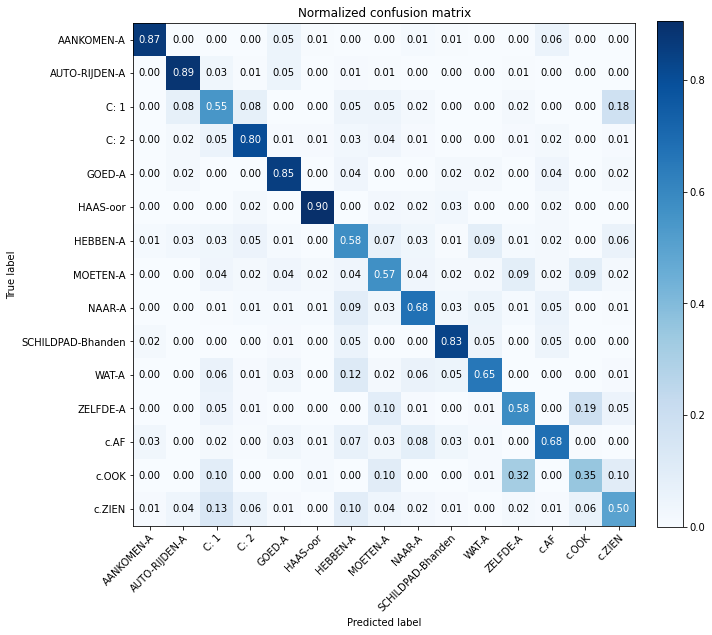

In [12]:
from utils_general.utils_for_students import label_encoder
from sklearn.model_selection import cross_val_predict
from utils_data_analysis.confusion_matrix import plot_confusion_matrix
CLASSES = label_encoder().inverse_transform([i for i in range(len(label_encoder().classes_))])
y_pred = cross_val_predict(cv.best_estimator_, X_train, y_train, cv=folds, n_jobs=5) 
plot_confusion_matrix(y_train, y_pred, classes=CLASSES, normalize=True)

In [13]:
print(cv.best_estimator_.final_estimator_.coef_.shape)

(15, 30)


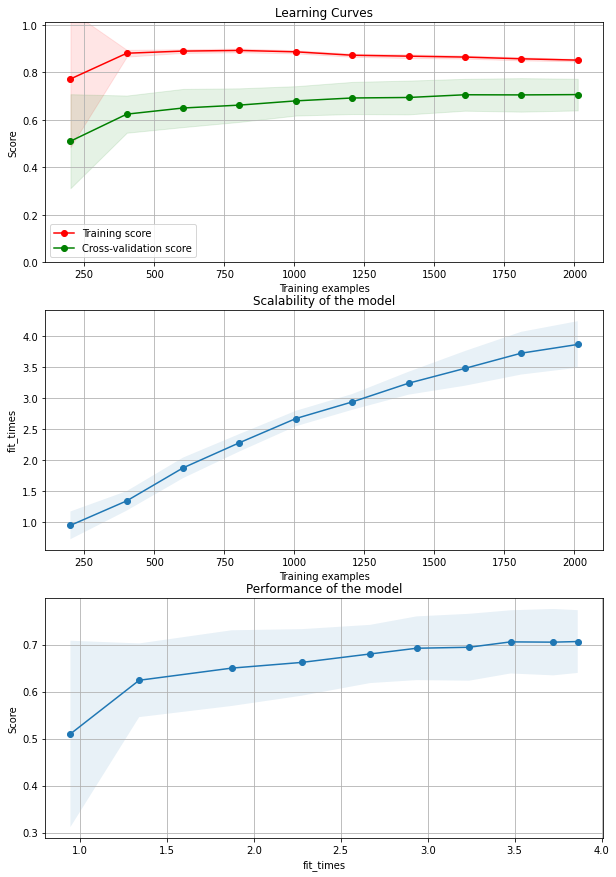

In [15]:
from utils_data_analysis.learning_curve import plot_learning_curve

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title = "Learning Curves"

plot_learning_curve(
    cv.best_estimator_, title, X_train, y_train, axes=axes, ylim=(0.0, 1.01), cv=folds, n_jobs=4,train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.show()